# Trabajo Practico N° 3
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini

In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from feature_engine.outliers import Winsorizer 

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay, classification_report)

In [61]:
dataset = pd.read_csv('dxWeather.csv')

In [62]:
#Creamos copia del dataset original
df = dataset.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


In [63]:
df.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [64]:
df.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


## Análisis exploratorio de datos

**Análisis del balanceo del dataset**

In [65]:
conteo = df['Estacion'].value_counts()

df_balanceo = pd.DataFrame({
    'Conteo': conteo,
    'Frecuencia de aparición': conteo / conteo.sum() * 100
})

df_balanceo

,Conteo,Frecuencia de aparición
Estacion,,
Primavera,2598,25.748266
Invierno,2500,24.777007
Otonio,2500,24.777007
Verano,2492,24.697721


esta balanceado

**Valores duplicados**

In [66]:
df.duplicated().values.any()

False

**Valores faltantes**

In [67]:
df.isna().sum()

Temperatura           0
Humedad               0
VientoVelocidad       0
Precipitation         0
PresionAtmosferica    0
Localizacion          0
TipoClima             0
Estacion              0
dtype: int64

**Codificación de variables categóricas**

In [68]:
# Convertir columnas categóricas en numéricas
df = pd.get_dummies(data=df, columns=['Localizacion', 'TipoClima'])

cols_bool = ['Localizacion_Costa', 'Localizacion_Llanura', 'Localizacion_Montania', 'TipoClima_Lluvioso',
       'TipoClima_Nevado', 'TipoClima_Nublado', 'TipoClima_Soleado']
df[cols_bool] = df[cols_bool].astype('int')

df.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Estacion,Localizacion_Costa,Localizacion_Llanura,Localizacion_Montania,TipoClima_Lluvioso,TipoClima_Nevado,TipoClima_Nublado,TipoClima_Soleado
0,39,96,8.5,71,1011.43,Primavera,0,1,0,0,0,1,0
1,30,64,7.0,16,1018.72,Primavera,0,0,1,0,0,0,1
2,38,83,1.5,82,1026.25,Primavera,1,0,0,0,0,0,1
3,32,55,3.5,26,1010.03,Verano,0,1,0,0,0,1,0
4,3,85,6.0,96,984.46,Invierno,0,1,0,0,1,0,0


**Distribuciones  y correlaciones de las variables**

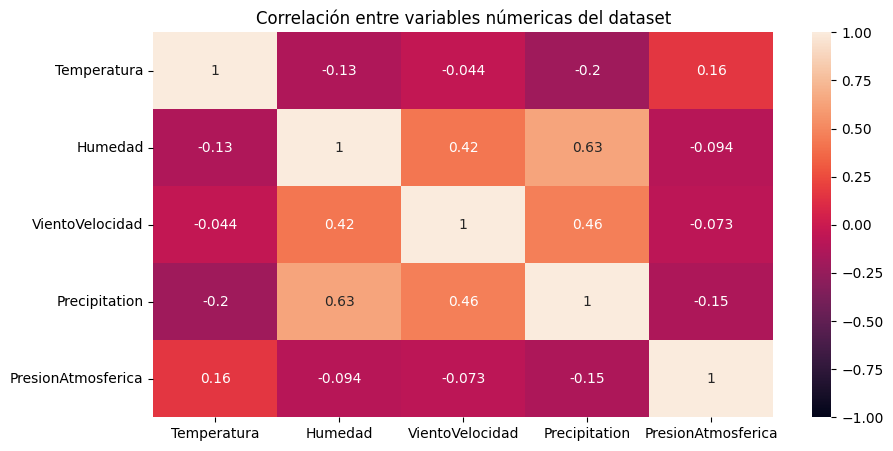

In [69]:
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

plt.figure(figsize=(10,5))
sns.heatmap(df[columnas_numericas].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

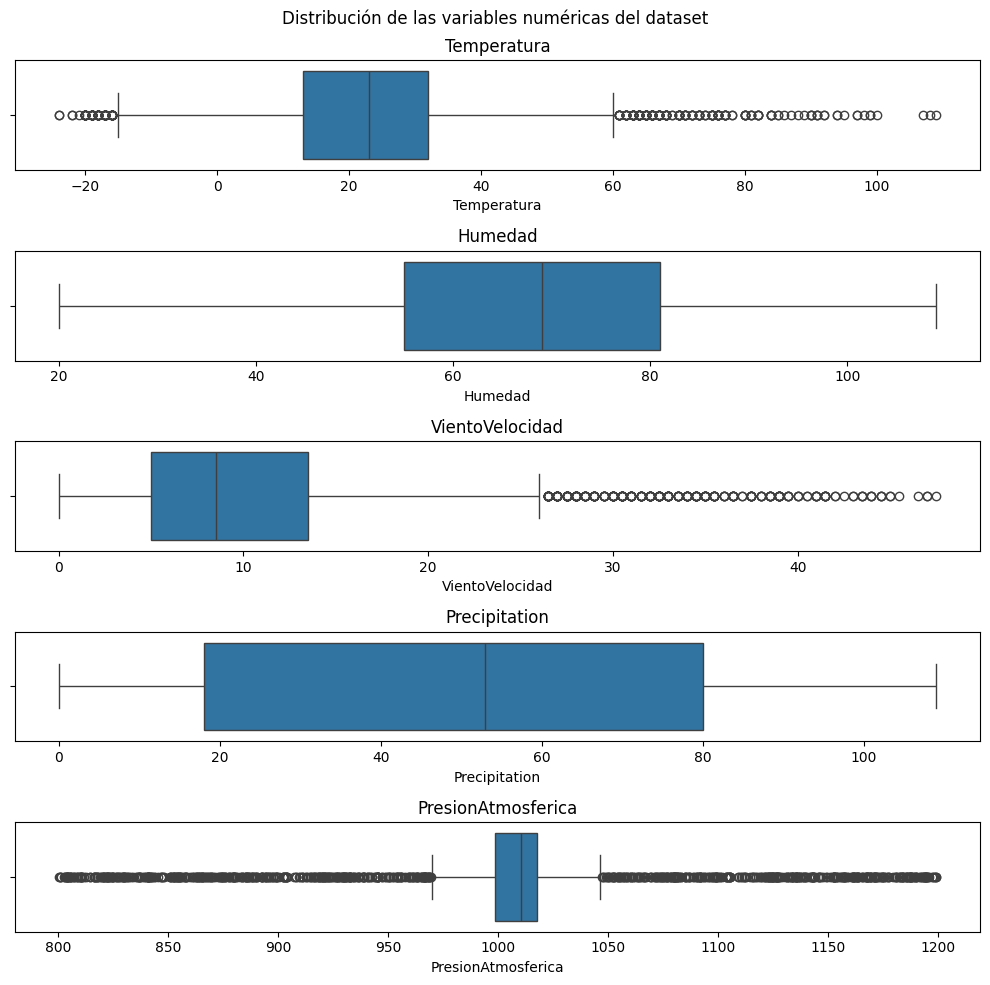

In [70]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

**Outliers**

In [71]:
# Temperatura: valores válidos hasta 50°C
df = df[df['Temperatura'] <= 50]

# Humedad: valores válidos hasta 100%
df = df[df['Humedad'] <= 100]

# Presión atmosférica: usando IQR para outliers
Q1 = df['PresionAtmosferica'].quantile(0.25)
Q3 = df['PresionAtmosferica'].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

df = df[(df['PresionAtmosferica'] >= lim_inf) & (df['PresionAtmosferica'] <= lim_sup)]


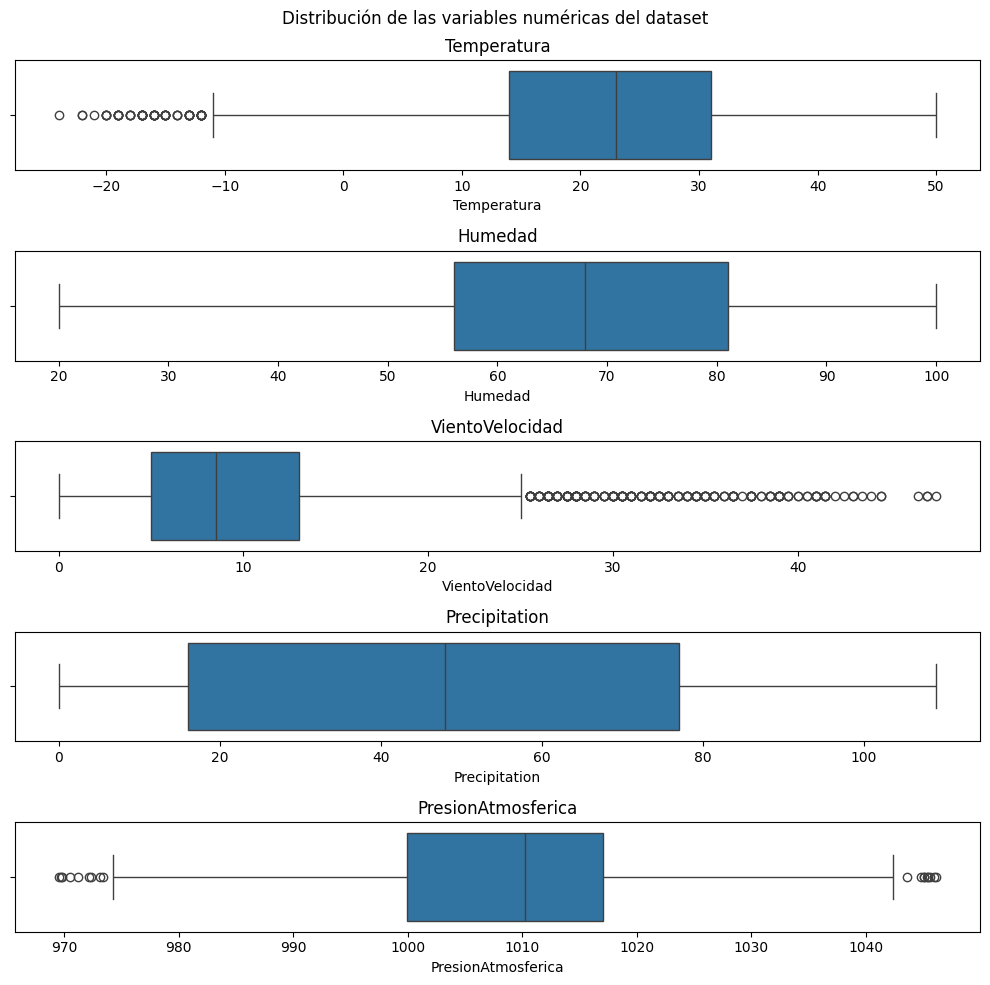

In [72]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset')
plt.tight_layout()
plt.show()

**División test-train**

In [73]:
X = df.drop(columns=['Estacion'])
y = df['Estacion']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## Máquinas de vectores: kernel linear

**Mejor modelo**

In [75]:
pipeline_base_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC())
])

In [76]:
# Ajuste de hiperparámetros
grilla_params_lineal = {
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lineal = GridSearchCV(
    estimator=pipeline_base_svm,
    param_grid=grilla_params_lineal,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_lineal.fit(X_train, y_train)

y_pred_lineal = grid_search_lineal.predict(X_test)

print(f"Mejor parámetro 'C' encontrado: {grid_search_lineal.best_params_}")
print(f"Mejor accuracy encontrado: {grid_search_lineal.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\juana\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Mejor parámetro 'C' encontrado: {'classifier__C': 0.1}
Mejor accuracy encontrado: 0.39021891053825153


**Métricas**

In [80]:
scores = cross_val_score(grid_search_lineal, X_test, y_test, cv = 5)
scores

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


array([0.38968481, 0.38108883, 0.42979943, 0.40401146, 0.4683908 ])

## Máquinas de vectores: kernel gaussiano

In [77]:
pipeline_base_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

In [78]:
# Ajuste de hiperparámetros
grilla_params_lineal = {
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.1, 1, 10, 100]
}

grid_search_lineal = GridSearchCV(
    estimator=pipeline_base_svm,
    param_grid=grilla_params_lineal,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_lineal.fit(X_train, y_train)

y_pred_lineal = grid_search_lineal.predict(X_test)

print(f"Mejor parámetro 'C' encontrado: {grid_search_lineal.best_params_}")
print(f"Mejor accuracy encontrado: {grid_search_lineal.best_score_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor parámetro 'C' encontrado: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
Mejor accuracy encontrado: 0.4011211387256187


## Random Forest

In [111]:
rf_base = RandomForestClassifier(random_state=1)

In [112]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, 30, None]
}

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor accuracy con CV=5:")
print(grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Mejores parámetros encontrados:
{'max_depth': 5, 'n_estimators': 50}

Mejor accuracy con CV=5:
0.3907932100193867


In [113]:
best_rf = grid_search.best_estimator_

best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=1)

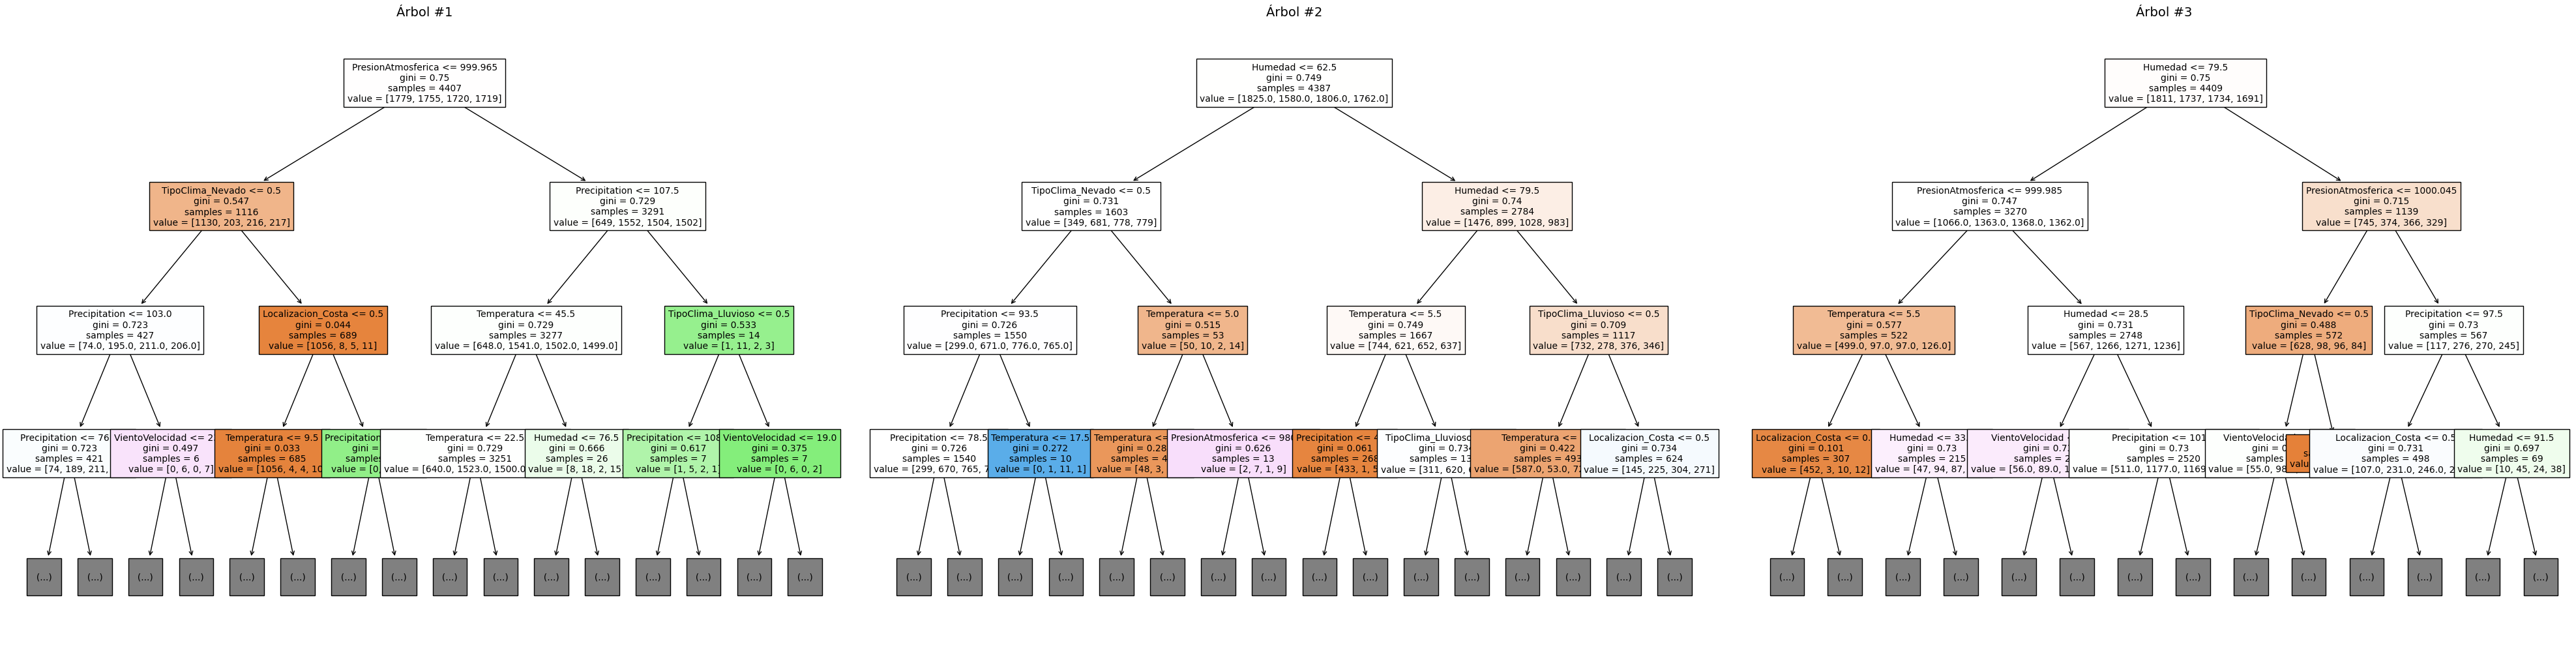

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 10))

# Recorrer los tres primeros árboles
for i in range(3):
    plot_tree(
        best_rf.estimators_[i],
        feature_names=X_train.columns,
        filled=True,
        max_depth=3,  # Limitar profundidad para mayor legibilidad
        fontsize=10,
        ax=axes[i]  # Plot en el subplot correspondiente
    )
    axes[i].set_title(f"Árbol #{i+1}", fontsize=14)

plt.tight_layout()
plt.show()

**Métricas**

In [115]:
y_pred = best_rf.predict(X_test)

print("Métricas en Test")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precisión:", precision_score(y_test, y_pred, average='weighted'))
print("Exhaustividad (Recall):", recall_score(y_test, y_pred, average='weighted'))

print("\nReporte completo:")
print(classification_report(y_test, y_pred))

Métricas en Test
Accuracy: 0.4025229357798165
Precisión: 0.47849902644879067
Exhaustividad (Recall): 0.4025229357798165

Reporte completo:
              precision    recall  f1-score   support

    Invierno       0.99      0.57      0.72       458
      Otonio       0.32      0.23      0.27       410
   Primavera       0.30      0.58      0.40       447
      Verano       0.27      0.21      0.24       429

    accuracy                           0.40      1744
   macro avg       0.47      0.40      0.41      1744
weighted avg       0.48      0.40      0.41      1744



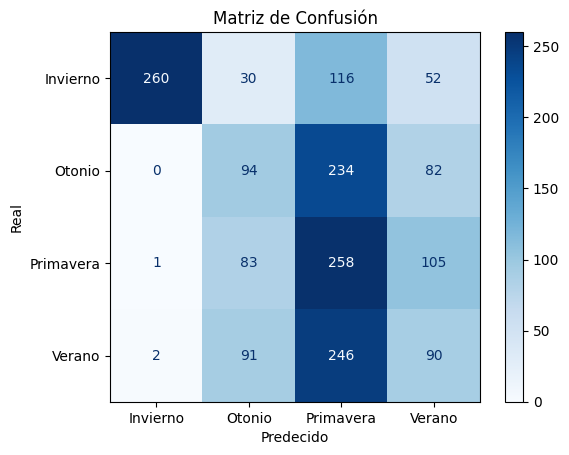

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión');

**Cross validation**

In [117]:
cv_results = cross_validate(
    best_rf,
    X_test,
    y_test,
    cv=5,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted']
)

In [118]:
print("\nValidación Cruzada en Test (k=5)")
print("Accuracy promedio:", cv_results['test_accuracy'].mean())
print("Precision promedio:", cv_results['test_precision_weighted'].mean())
print("Recall promedio:", cv_results['test_recall_weighted'].mean())

print("\nDesviaciones estándar:")
print("Accuracy:", cv_results['test_accuracy'].std())
print("Precision:", cv_results['test_precision_weighted'].std())
print("Recall:", cv_results['test_recall_weighted'].std())


Validación Cruzada en Test (k=5)
Accuracy promedio: 0.40770510160392587
Precision promedio: 0.4652395032062759
Recall promedio: 0.40770510160392587

Desviaciones estándar:
Accuracy: 0.028834982862418024
Precision: 0.026552201305701354
Recall: 0.028834982862418024
